# dividends vs no-dividends

compare SPY with and without dividends

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Timeseries

In [4]:
# fetch timeseries, select, finalize
ts = pf.fetch_timeseries(symbol)
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)
ts, start = pf.finalize_timeseries(ts, start)

# create tradelog and daily balance objects
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

In [5]:
ts

,high,low,open,close,volume,adj_close
date,,,,,,
1993-01-29,25.90,25.77,25.90,25.88,1003200.00,25.88
1993-02-01,26.07,25.90,25.90,26.07,480500.00,26.07
1993-02-02,26.14,25.99,26.05,26.12,201300.00,26.12
1993-02-03,26.42,26.14,26.16,26.40,529400.00,26.40
1993-02-04,26.57,26.20,26.49,26.51,531500.00,26.51
...,...,...,...,...,...,...
2021-03-22,394.07,389.97,390.03,392.59,73778600.00,392.59
2021-03-23,393.46,388.66,391.91,389.50,90686600.00,389.50
2021-03-24,392.75,387.47,391.00,387.52,97588600.00,387.52


Algorithm

In [6]:
pf.TradeLog.cash = capital

# loop through timeseries
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # buy
    if tlog.shares == 0:
        tlog.buy(date, row.close)
    # sell
    elif end_flag:
        tlog.sell(date, row.close)

    # record daily balance
    dbal.append(date, row.high, row.low, row.close)

Retrieve logs and get stats

In [7]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)
stats = pf.stats(ts, tlog, dbal, capital)

Benchmark: Run, retrieve logs, generate stats

In [8]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=False)
benchmark.run()

Plot Equity Curves: Dividends (strategy) vs No-Dividends (benchmark)

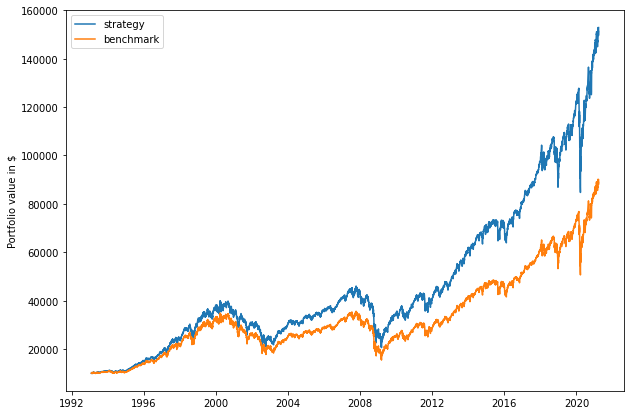

In [9]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal, fname='equity_curve.png')

Dividends (strategy) vs No-Dividends (benchmark)

In [10]:
pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$152,856.99","$89,913.65"
total_net_profit,"$142,856.99","$79,913.65"
gross_profit,"$142,856.99","$79,913.65"
gross_loss,$0.00,$0.00


,strategy,benchmark
annual_return_rate,10.17,8.11
max_closed_out_drawdown,-55.18,-56.43
annualized_return_over_max_drawdown,0.18,0.14
best_month,23.61,23.06
worst_month,-30.98,-31.38
sharpe_ratio,0.61,0.51
sortino_ratio,0.77,0.64
monthly_std,4.47,4.47
annual_std,16.71,16.36
avg_month,0.87,0.72


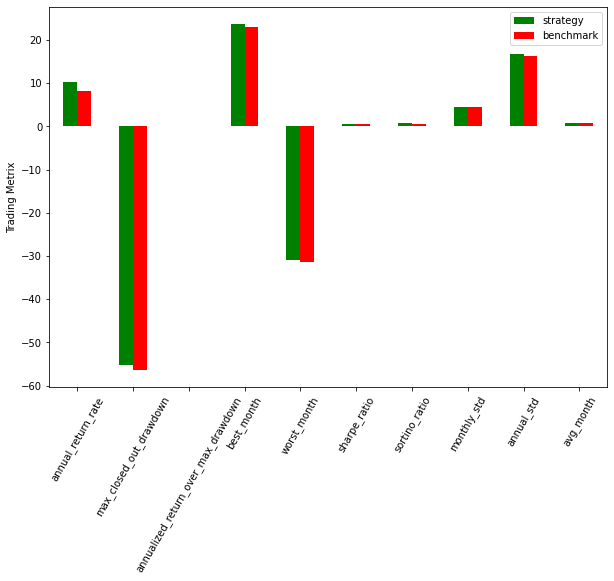

In [11]:
pf.plot_bar_graph(stats, benchmark.stats, extras=('avg_month',))